In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

In [5]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# find latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# format the string
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
# get the date 1 year before
last_year = latest_date - relativedelta(months=+12)
# show date twelve months before
last_year

datetime.datetime(2016, 8, 23, 0, 0)

In [10]:
# query for the last 12 months of precipitation data
last_twelve_months = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date >= last_year).group_by(Measurement.date).all()

In [11]:
# saving results to dataframe
prcp_df = pd.DataFrame(last_twelve_months, columns=['date', 'prcp'])
# set date to index
prcp_df.set_index('date', inplace=True)
# show dataframe
prcp_df.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [12]:
# create lists of date and precipitation
date = prcp_df.index
prcp = prcp_df['prcp']

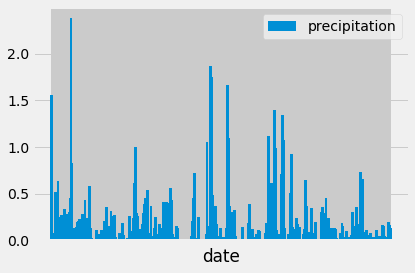

In [24]:
# create the figure
fig, ax = plt.subplots()
# plot the data
ax.bar(date, prcp, label="precipitation", width=3)
# clear xticklabels
ax.set_xticklabels("")
# set xlabel
ax.set_xlabel("date")
# create a legend
ax.legend()
# show the plot
plt.show()

In [14]:
# rename a row for the display
prcp_df_rename = prcp_df.rename(columns={'prcp': 'precipitation'})
# display summary statistics
prcp_df_rename.describe()

,precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [15]:
# query to obtain the number of stations
number_of_stations = session.query(Measurement.station).distinct(Measurement.station).count()
# show number of stations
number_of_stations

9

In [16]:
# query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# show the most active stations
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# find most active station
most_active_station = most_active_stations[0][0]
# find min, max, and avg temps for this station
most_active_station_max_min_avg = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
# show the results
most_active_station_max_min_avg

[(54.0, 71.66378066378067, 85.0)]

In [19]:
# query for the last 12 months of tobs for the most active station
most_active_station_data = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).all()
# create dataframe
most_active_station_data_df = pd.DataFrame(most_active_station_data, columns=['station', 'tobs'])
# set station as index
most_active_station_data_df.set_index('station', inplace=True)
# show dataframe
most_active_station_data_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


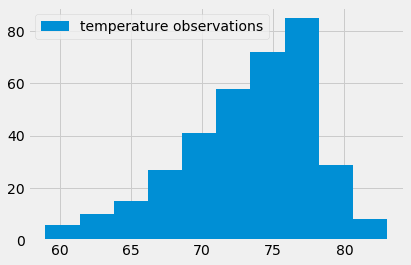

In [20]:
# plot the results as a histogram
# create the figure
fig, ax = plt.subplots()
# plot the data
ax.hist(most_active_station_data_df['tobs'], label='temperature observations')
# create a legend
ax.legend()
# show the plot
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
trip_temps = calc_temps('2016-02-28', '2016-03-05')
trip_temps

[(62.0, 69.88636363636364, 80.0)]

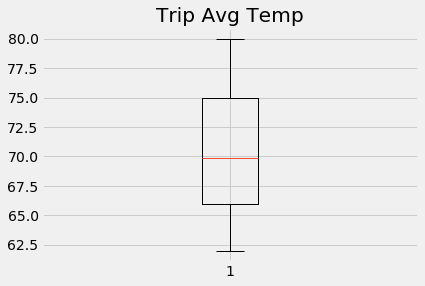

In [25]:
fig, ax = plt.subplots()
ax.boxplot(trip_temps)
ax.set_title('Trip Avg Temp')
plt.show()